In [1]:
import napari
from napari.utils import nbscreenshot
import numpy as np
import pandas as pd
import scanpy as sc

from morphometrics.data import cylinders_and_spheres
from morphometrics.explore.cluster import cluster_features
from morphometrics.explore.dimensionality_reduction import pca, umap
from morphometrics.measure import measure_selected
from morphometrics.utils.anndata_utils import table_to_anndata

rng = np.random.default_rng(42)

In [2]:
# load the sample images
label_image, label_table, intensity_image = cylinders_and_spheres()

In [3]:
# add the sample images to the viewer
viewer = napari.view_labels(label_image, features=label_table)
viewer.add_image(intensity_image)

<Image layer 'intensity_image' at 0x7f8c391ba970>

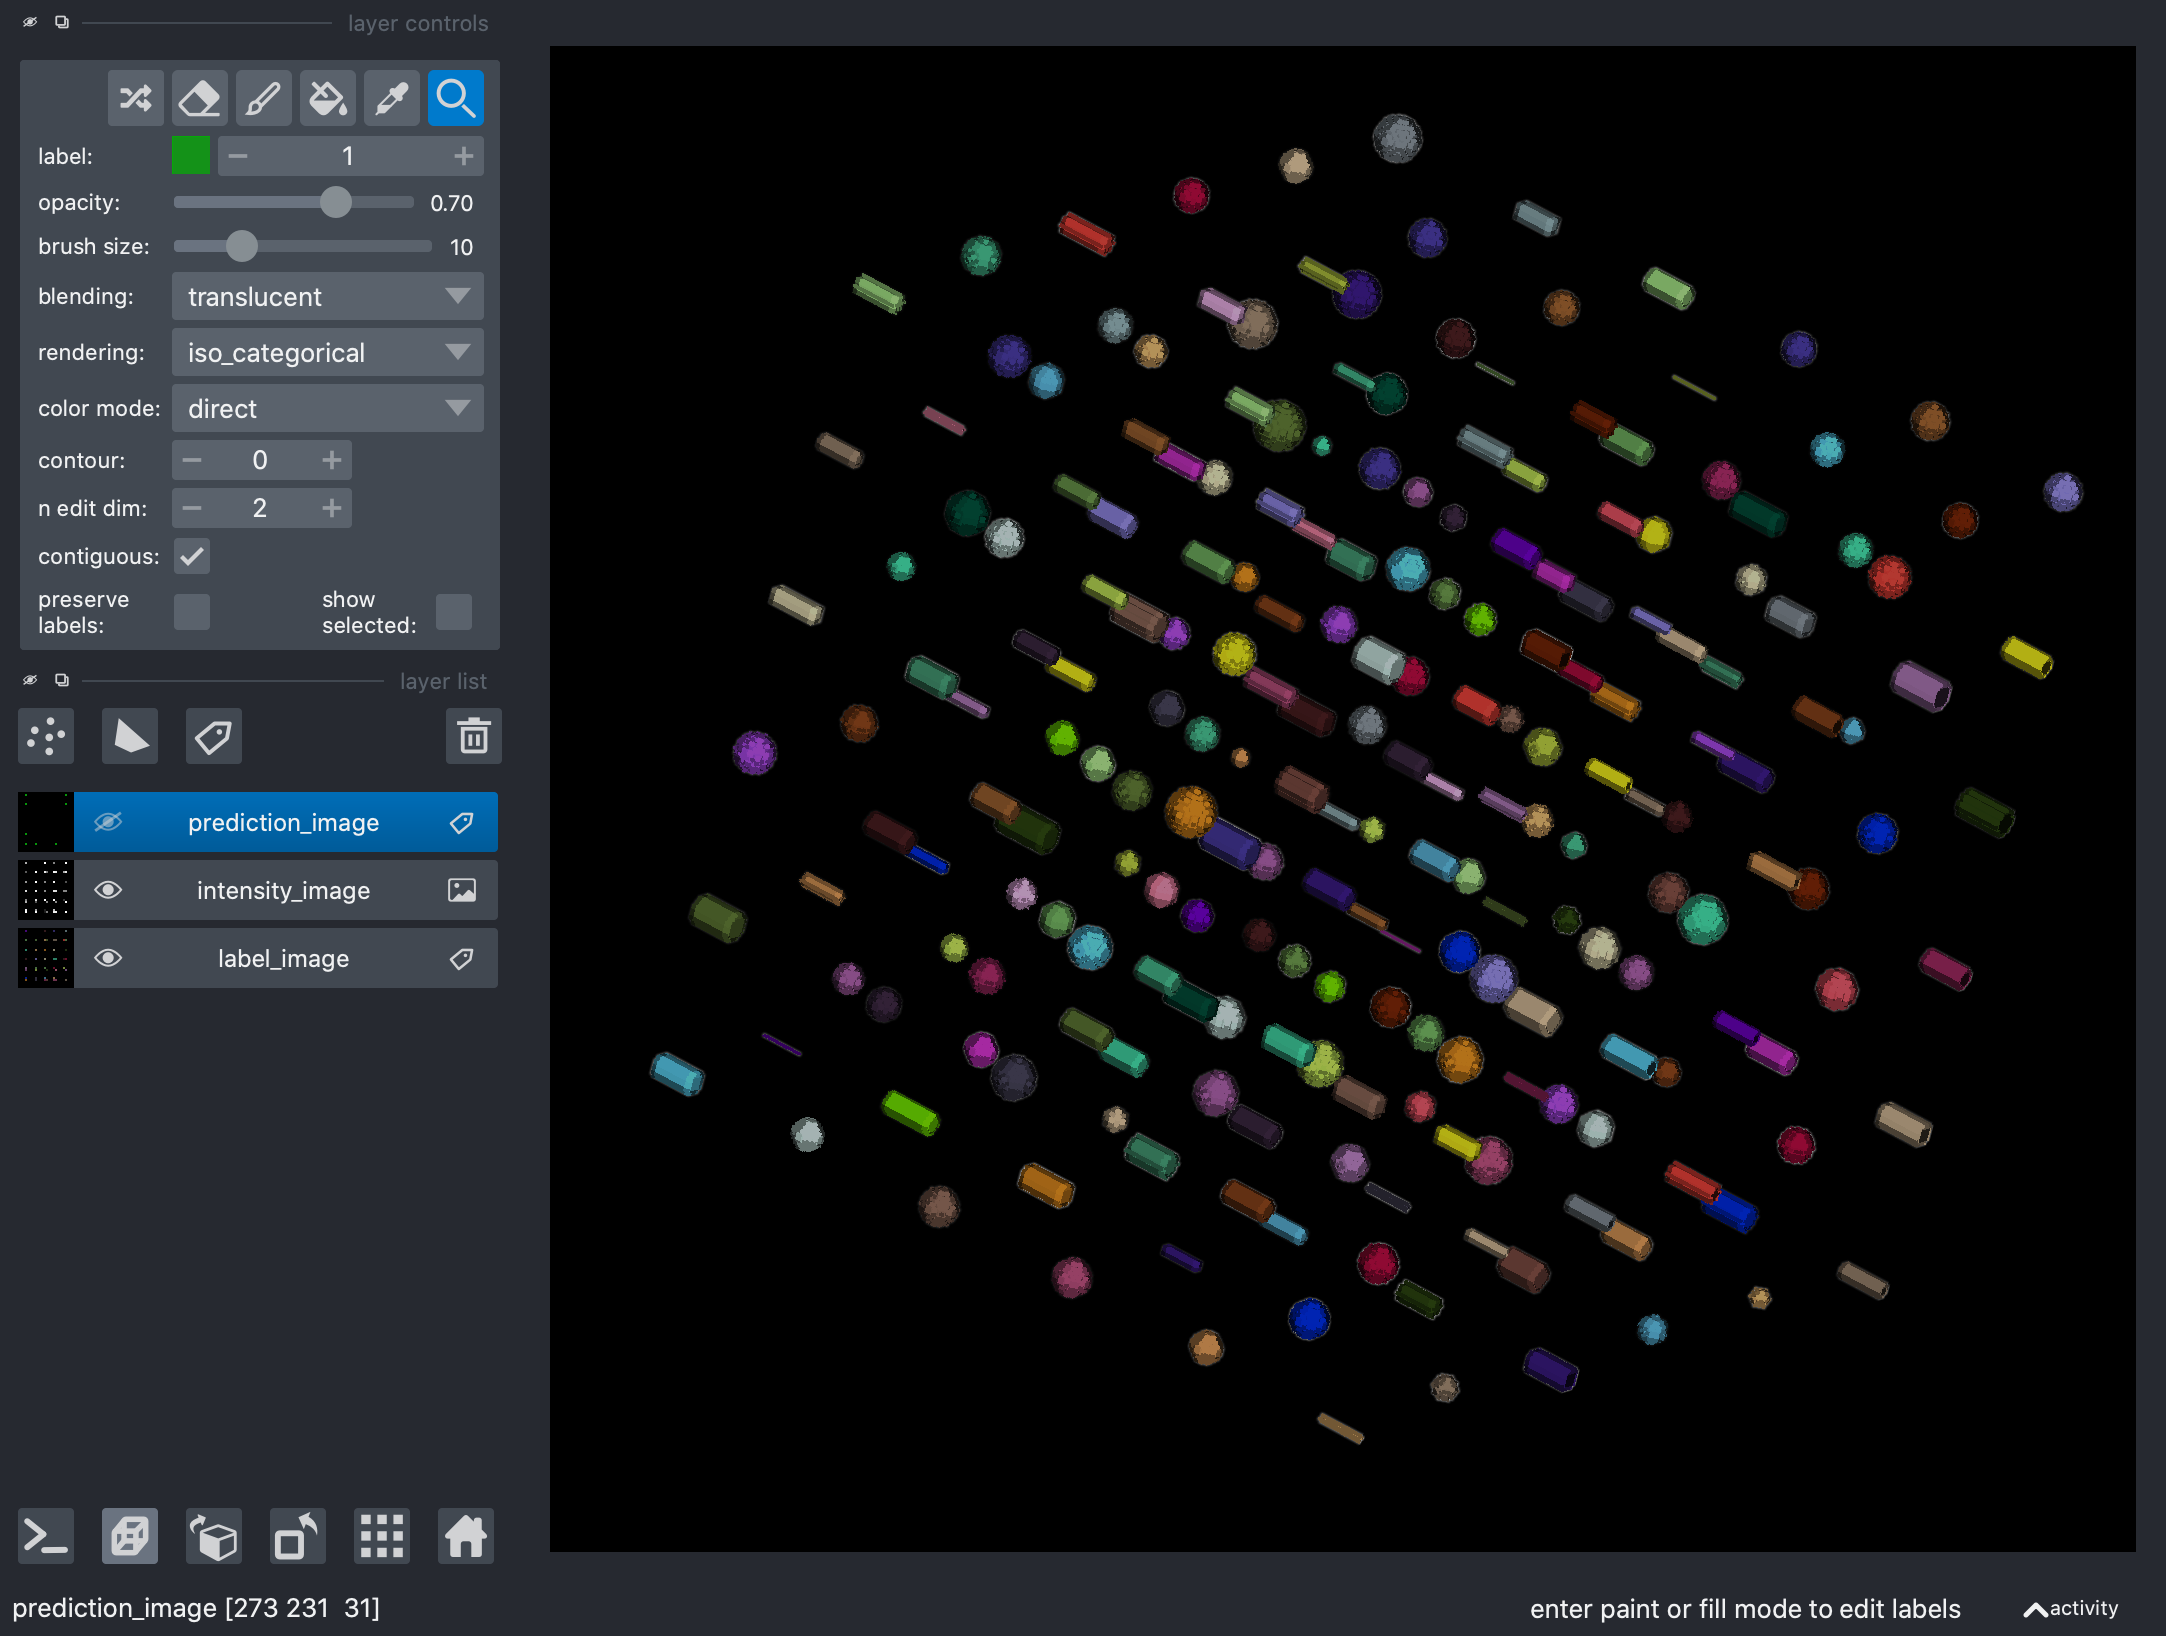

In [18]:
nbscreenshot(viewer)

In [5]:
# make the measurements

measurement_selection = [
    "surface_properties_from_labels",
    {
        "name": "regionprops",
        "choices": {
             "size": False,
            "intensity": True,
            "position": False,
            "moments": False
        },
    },
]

all_measurements = measure_selected(
    label_image=label_image,
    intensity_image=intensity_image,
    measurement_selection=measurement_selection,
)

all_measurements.head()

,surface_area,curvature_mean,curvature_stdev,curvature_0,curvature_10,curvature_20,curvature_30,curvature_40,curvature_50,curvature_60,curvature_70,curvature_80,curvature_90,curvature_100,max_intensity,mean_intensity,min_intensity,standard_deviation_intensity
label,,,,,,,,,,,,,,,,,,
1,431.539821,-14.174583,2.718100,-28.160018,-16.311390,-15.543505,-15.100626,-14.588082,-14.236206,-13.859509,-13.351810,-12.231456,-10.457056,-8.447891,0.965651,0.965651,0.965651,1.110223e-16
2,515.625191,-12.230682,0.642772,-13.774117,-13.110218,-12.908614,-12.688435,-12.311259,-12.118124,-11.842123,-11.736034,-11.668173,-11.582039,-11.221591,0.549398,0.549398,0.549398,2.220446e-16
3,349.871722,-16.370577,2.782248,-25.453676,-19.075474,-17.519248,-17.218528,-17.026573,-16.678844,-15.879726,-15.689523,-13.802004,-12.637379,-10.864902,0.941239,0.941239,0.941239,2.220446e-16
4,349.507141,-16.673350,2.888261,-24.784948,-19.767262,-18.742127,-18.287274,-17.870555,-16.552620,-16.280190,-15.698353,-13.738252,-13.006505,-11.398300,0.048312,0.048312,0.048312,6.938894e-18
5,495.691402,-12.417467,0.269589,-13.028942,-12.689400,-12.654743,-12.530923,-12.455418,-12.443071,-12.392187,-12.294498,-12.236039,-12.087494,-11.658909,0.130993,0.130993,0.130993,5.551115e-17


In [6]:
# convert the measurement table to an AnnData object
measurement_data = table_to_anndata(
    measurement_table=all_measurements,
    obs=label_table
)

print(measurement_data)

AnnData object with n_obs × n_vars = 216 × 18
    obs: 'label', 'shape'
    var: 0


/Users/kyamauch/opt/miniconda3/envs/morphometrics/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


... storing 'shape' as categorical


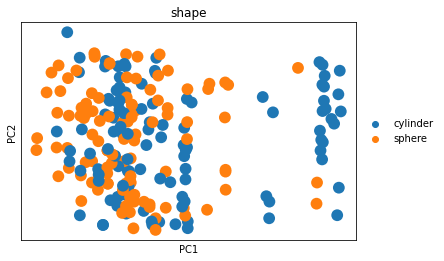

In [7]:
# Use PCA to reduce dimensionality
%matplotlib inline

pca(measurement_data, normalize_data=True)
sc.pl.pca(measurement_data, color=['shape'])

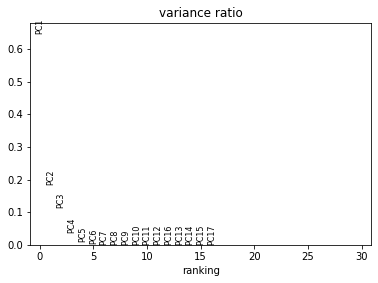

In [8]:
# plot the variation per priniciple component to determine
# how many principle components we need to build the neighbor
# graph
sc.pl.pca_variance_ratio(measurement_data)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


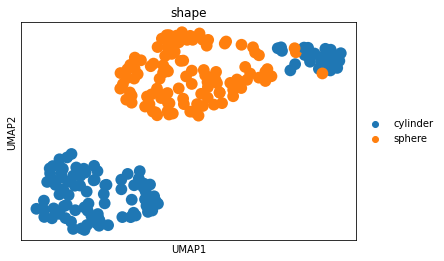

In [9]:
# Build the neighbor graph and calculate UMAP
cluster_features(
    measurement_data,
    method="leiden",
    compute_neighbors=True,
    neighbors_kwargs={"n_pcs": 6}
)

umap(measurement_data, compute_neighbors=False)
sc.pl.umap(measurement_data, color='shape')

In [10]:
# add the UMAP coordinates to the napari labels layer features
labels_features = viewer.layers['label_image'].features
labels_features['umap_0'] = measurement_data.obsm['X_umap'][:, 0]
labels_features['umap_1'] = measurement_data.obsm['X_umap'][:, 1]

viewer.layers['label_image'].features = labels_features

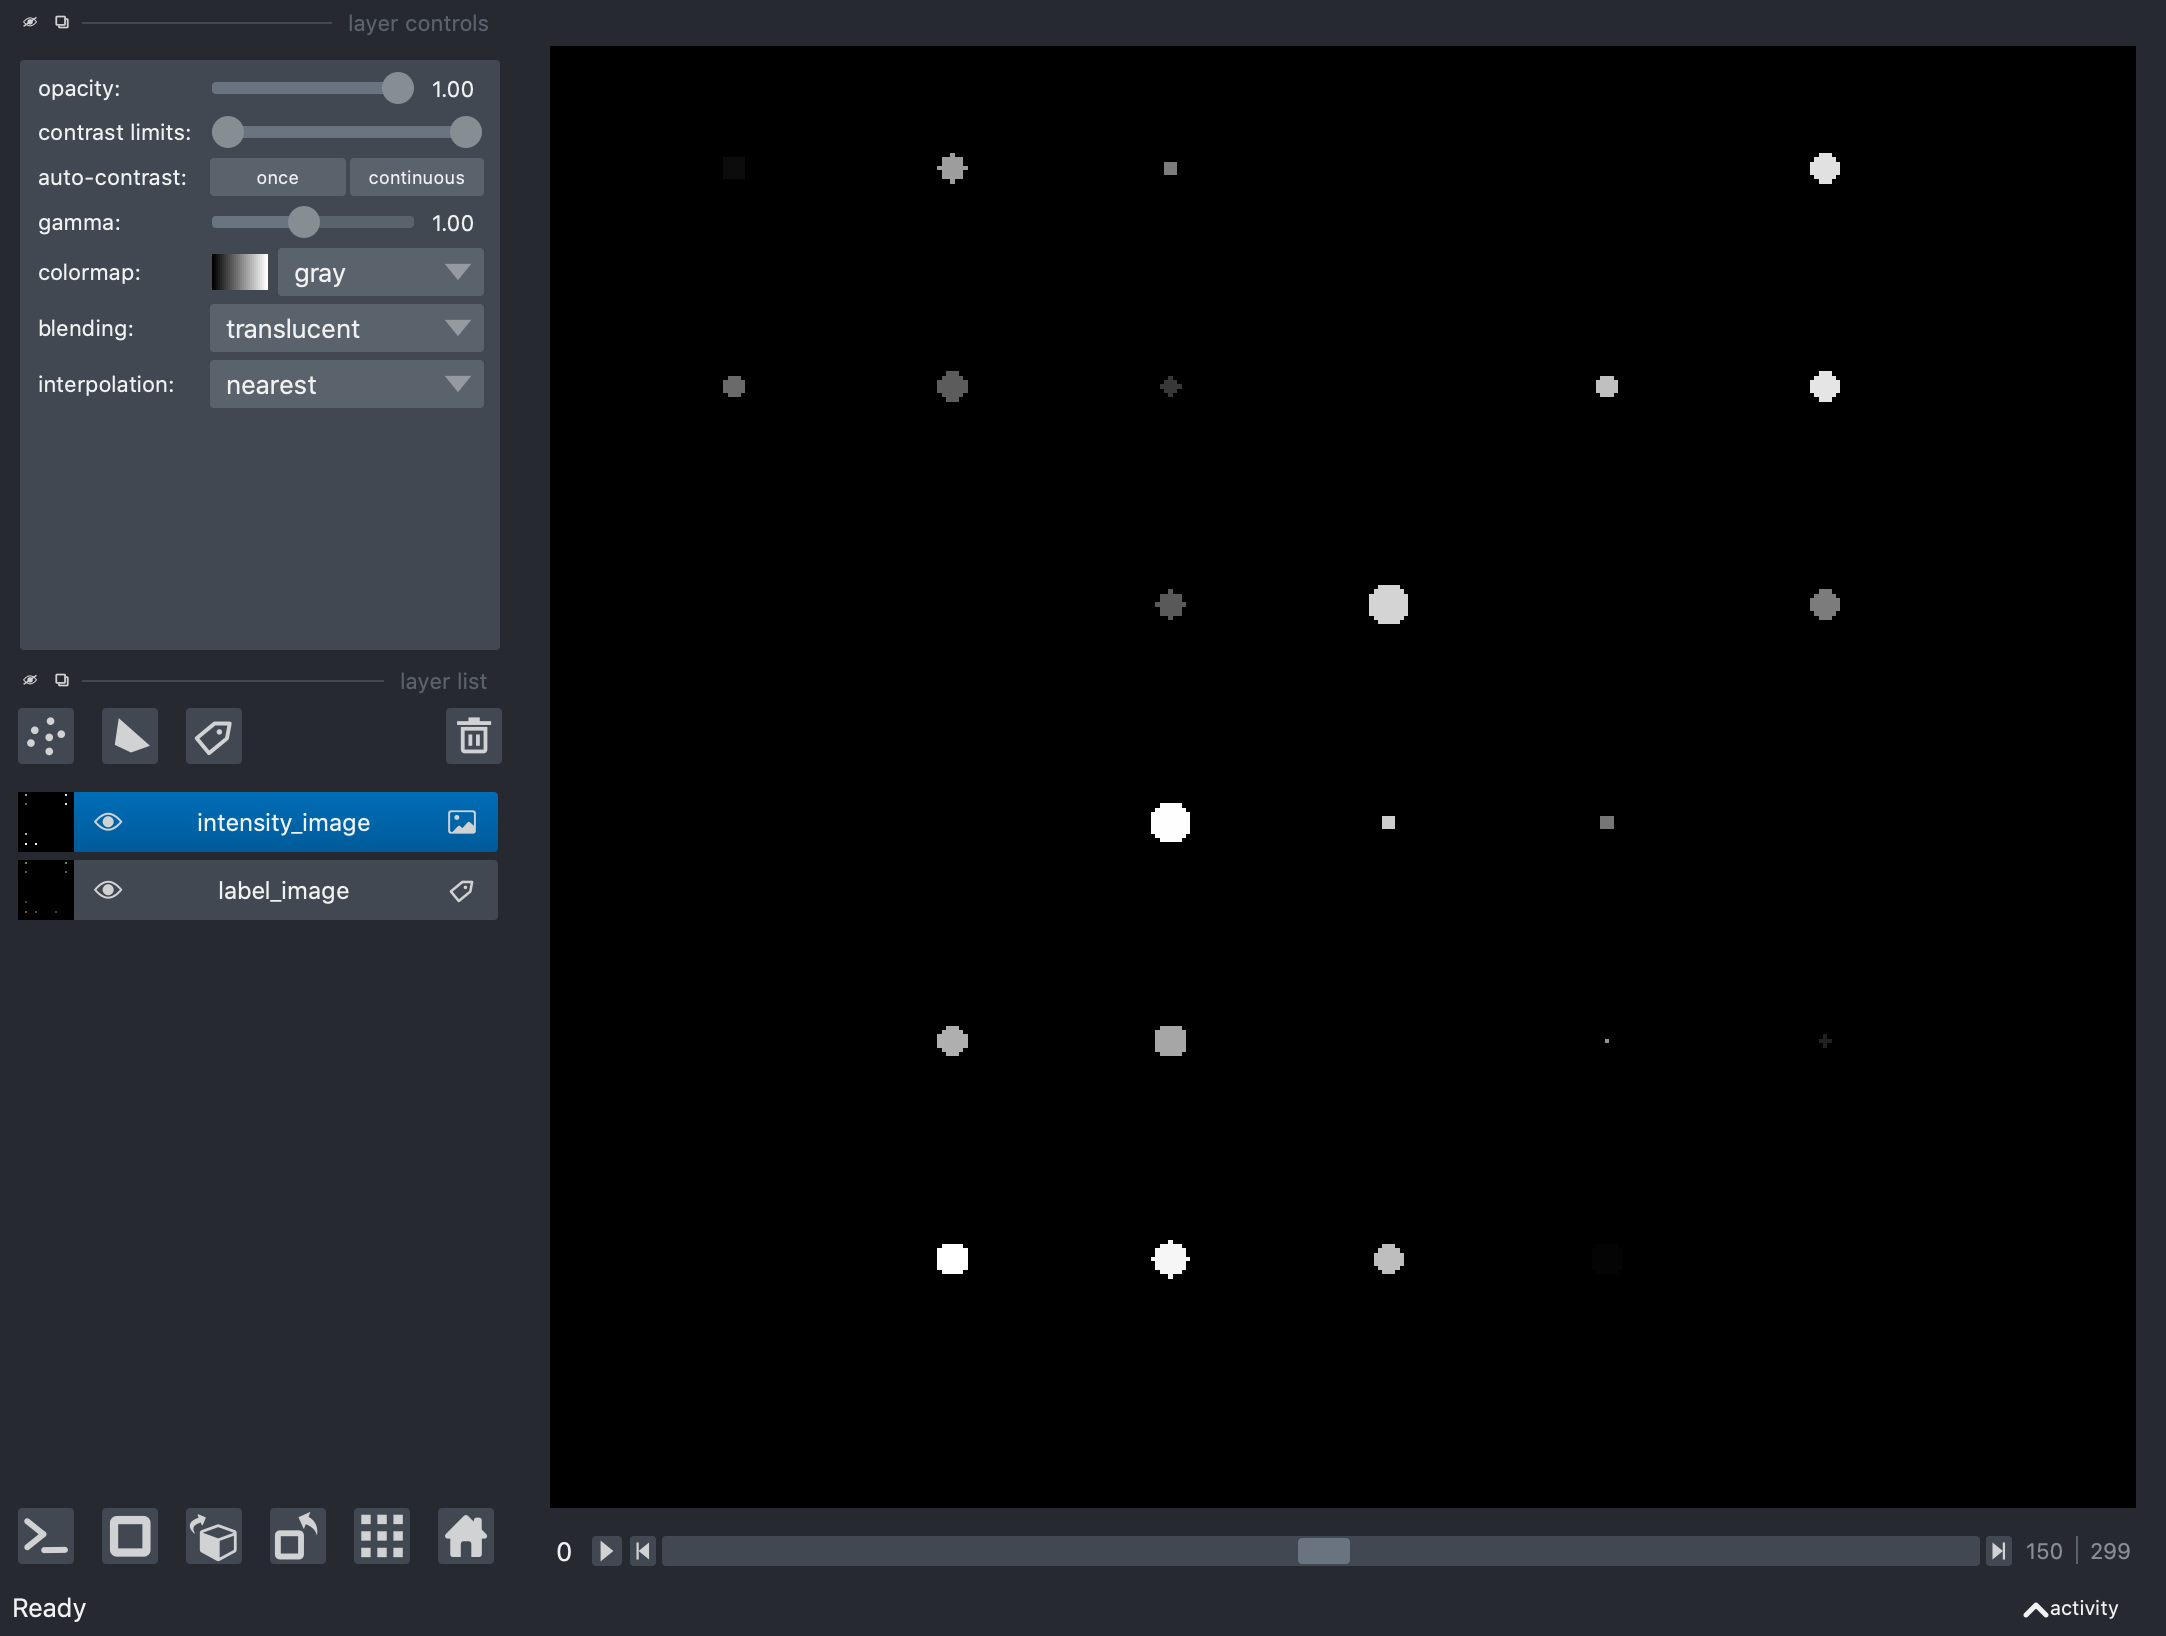

In [11]:
# You can use the "Plotter widget" from the napari-clusters-plotter
# plugin to select objects from the UMAP
nbscreenshot(viewer)

In [12]:
# encode the shape as 0=cylinder and sphere=1 so we can train
# a random forest classifier to predict shape from the
# measured features
obs = measurement_data.obs
obs['shape_label'] = obs['shape'].map({'cylinder': 0, 'sphere': 1})
y = obs['shape_label'].to_numpy()

In [13]:
from sklearn.model_selection import train_test_split

# spit the data into test and train sets
X = measurement_data.X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [14]:
from sklearn.ensemble import RandomForestClassifier

# train the random forest classifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
from sklearn import metrics

# test the classifier performance on the test data set
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [16]:
# display predictions in napari viewer

y_pred_all = clf.predict(X)

prediction_image = np.zeros_like(label_image)

for shape_prediction, label_index in zip(y_pred_all, obs['label']):
    prediction_image[label_image == label_index] = shape_prediction + 1

viewer.add_labels(prediction_image, color={1: [0, 1, 0, 1], 2: [1, 0, 1, 1]})

<Labels layer 'prediction_image' at 0x7f8bdb709850>

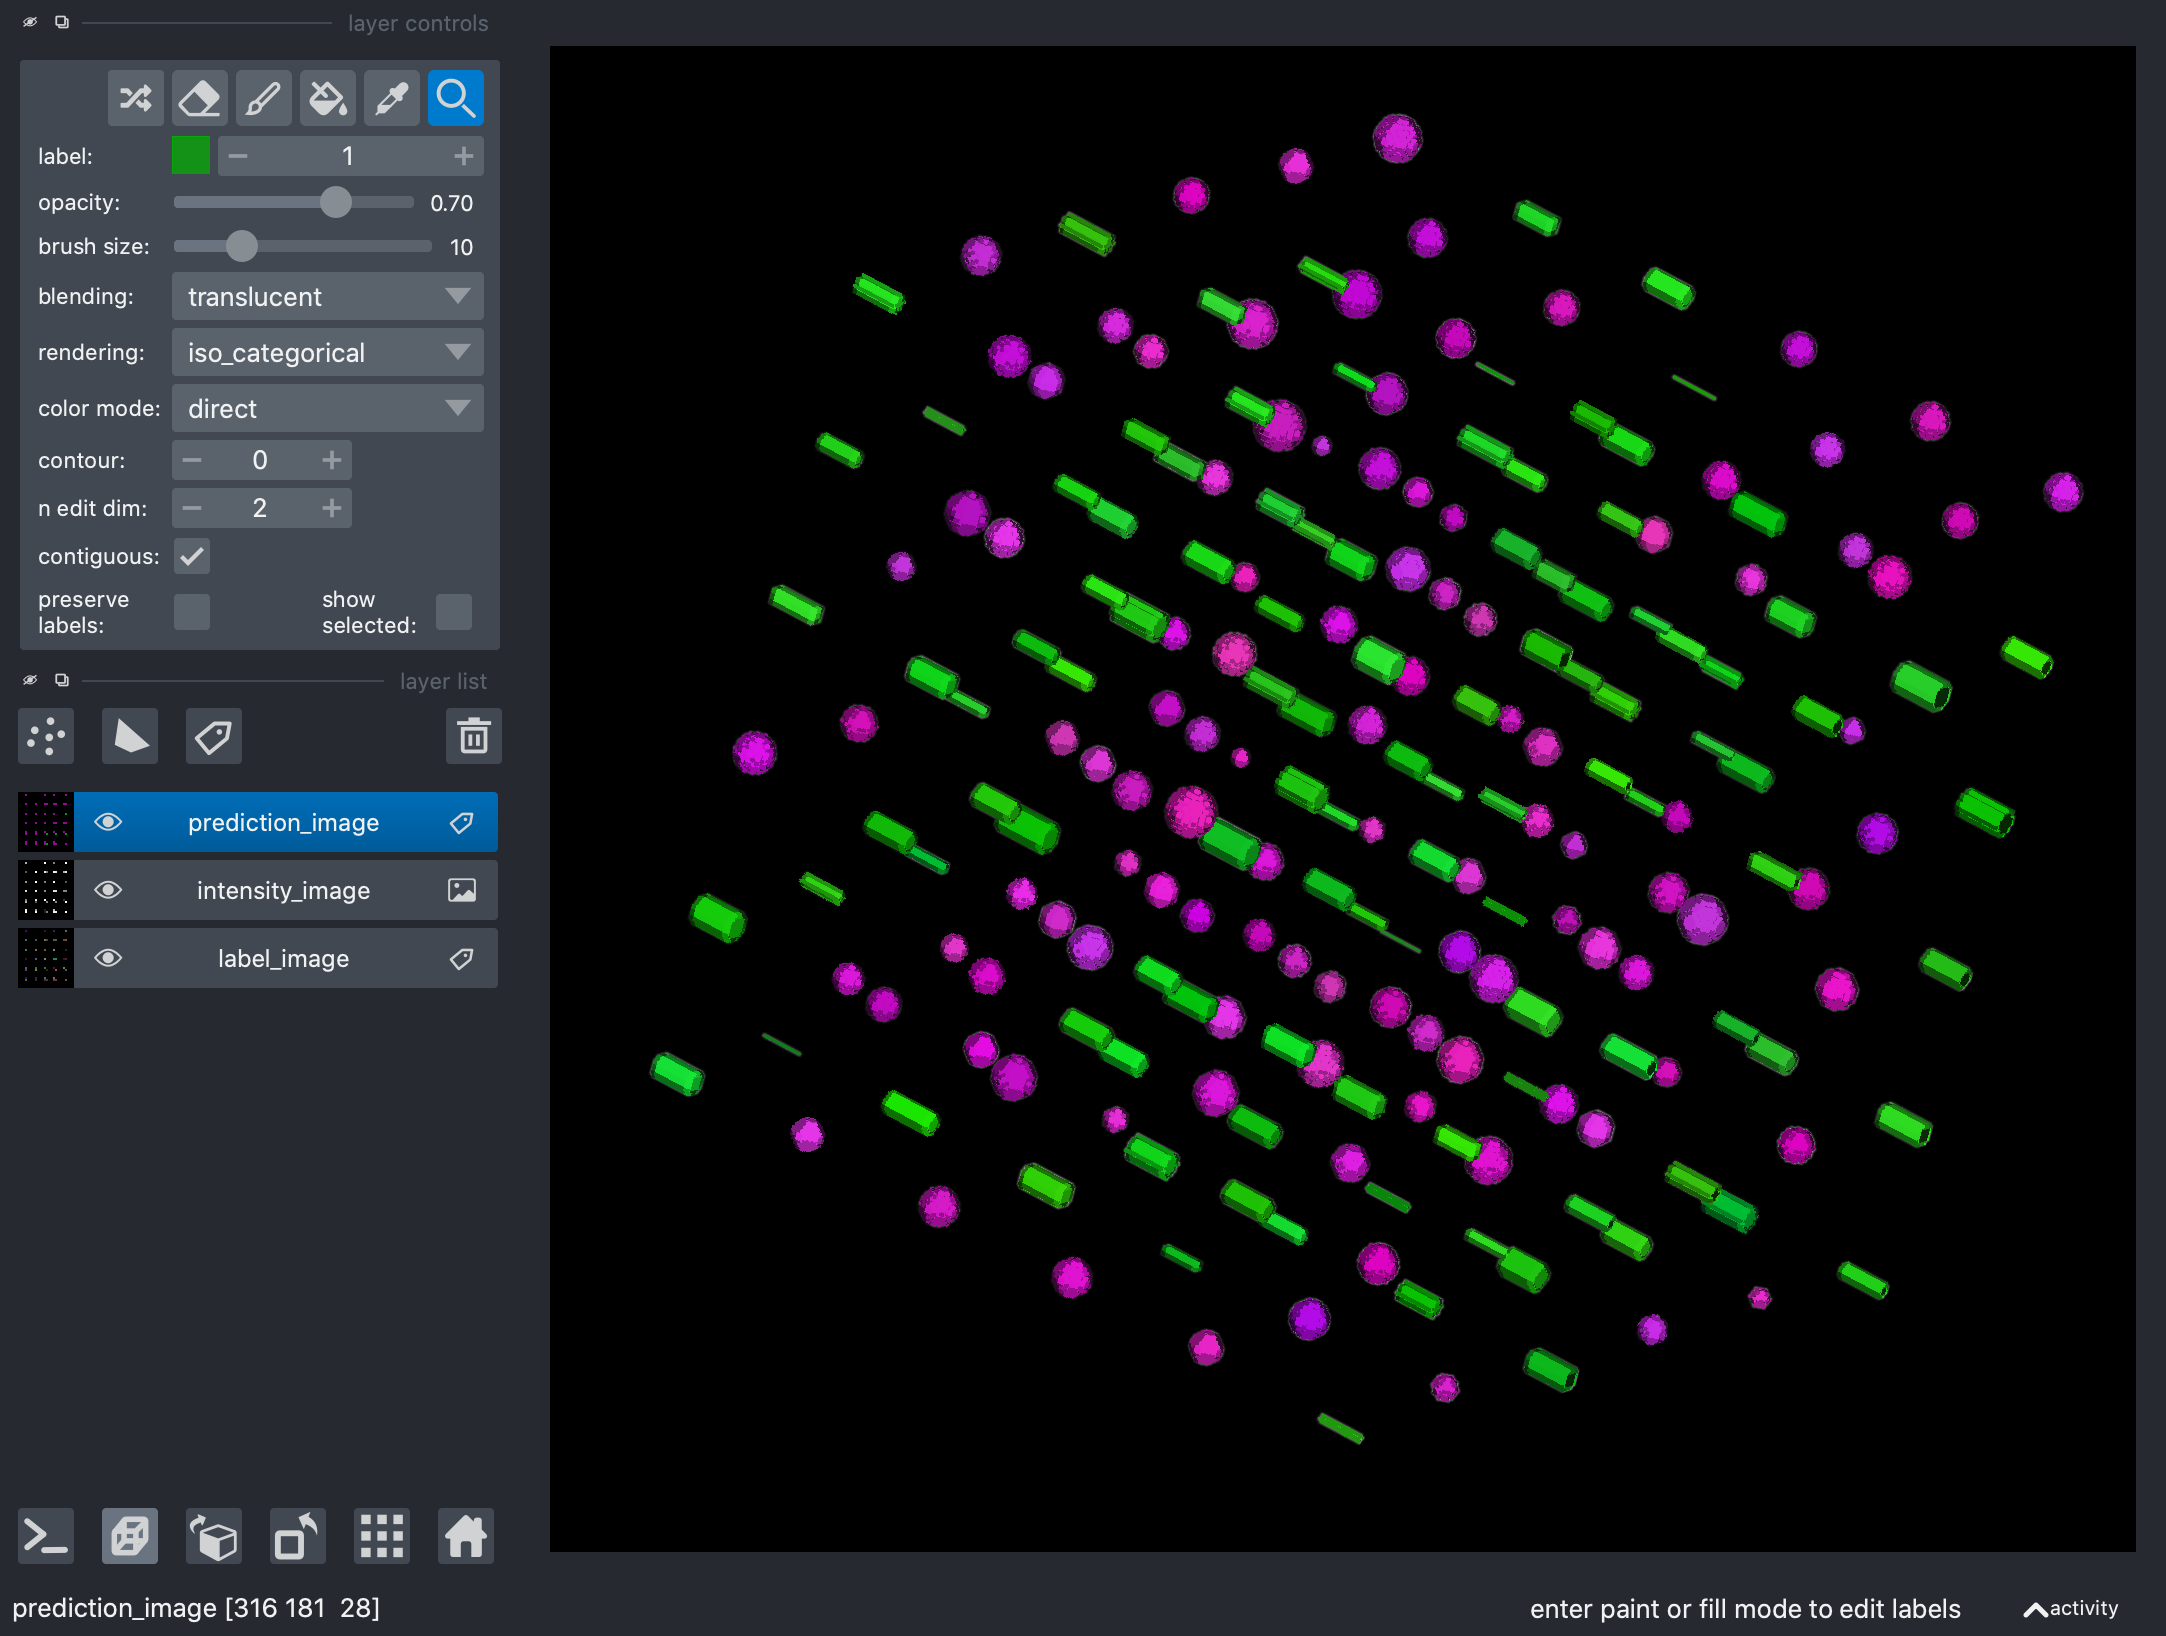

In [19]:
# predicted spheres shown in magenta and cylinders in green!
nbscreenshot(viewer)